Две необходимых ссылки
https://pysindy.readthedocs.io/en/latest/examples/index.html

https://pysindy.readthedocs.io/en/latest/examples/2_introduction_to_sindy/example.html

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import random

from plotly.subplots import make_subplots
from scipy.integrate import solve_ivp
import torch 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import pysindy as ps

# Генерация данных как в CRNN-модели

## Функция для вычисления приращений концентраций веществ

In [2]:
def true_ode_func(t: float, y: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : np.array
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : np.array
        Константы скоростей реакций (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    
    dydt = np.empty_like(y)                          # можно использовать np.zeros_like(y), но это быстрее
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

## Константы

In [3]:
N_REACTION = 4                                                       # кол-во реакций
N_SUBSTANCE = 5                                                      # кол-во веществ
VR_TIME = 30                                                         # время протекания реакций
INIT_CONC = np.array([0.8, 0.5, 0.1, 0, 0])                          # начальные концентрации веществ
k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)         # константы скоростей реакций

tspan = [0.0, VR_TIME]                                               # временной промежуток
tsteps = np.linspace(tspan[0], tspan[1], VR_TIME*2 + 1)                # шаги по временному промежутку (количество точек)

# Стехиометрическая матрица (матрица реакций) в базовом виде
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

MATR_PLUS = np.where(MATR < 0, -MATR, 0)
print(MATR_PLUS)

[[2 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]]


## Вычисление и визуализация изменения концентраций веществ со временем

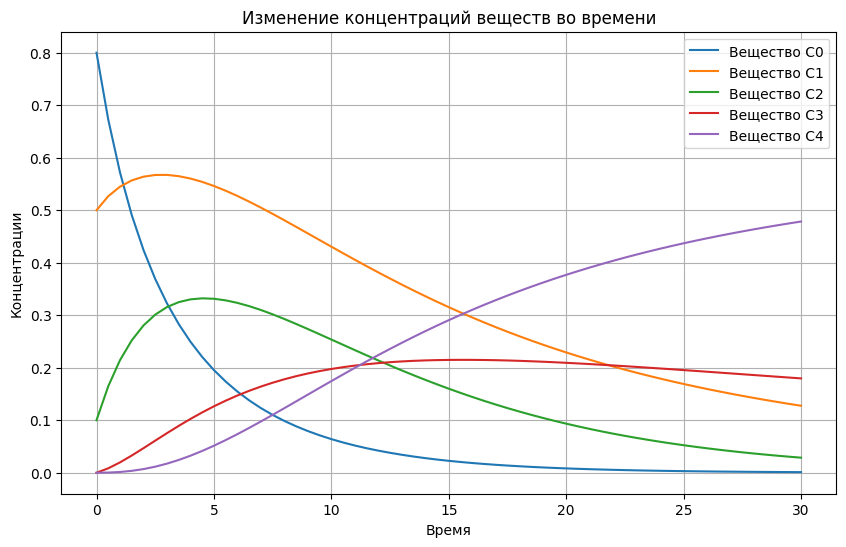

Начальные концентрации:        [0.8 0.5 0.1 0.  0. ]
Сумма концентраций веществ:    1.4000000000000001
Концентрации после 30 секунд:  [0.02508936 0.32563066 0.16832819 0.21451112 0.28027   ]
Сумма концентрций веществ:     1.0138293308989867


In [4]:
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        INIT_CONC,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество C{i}')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", INIT_CONC)
print("Сумма концентраций веществ:   ", sum(INIT_CONC))
print(f"Концентрации после {VR_TIME} секунд:  {sol.y[:, VR_TIME - 1]}")
print("Сумма концентрций веществ:    ", sum(sol.y[:, VR_TIME - 1]))

# Сохранение сгенерированных концентраций C в моменты времени. Понадобятся в будущем
CONC_TRUE = sol.y.copy()

## Вычисление приращений концентраций со временем (прямая задача)

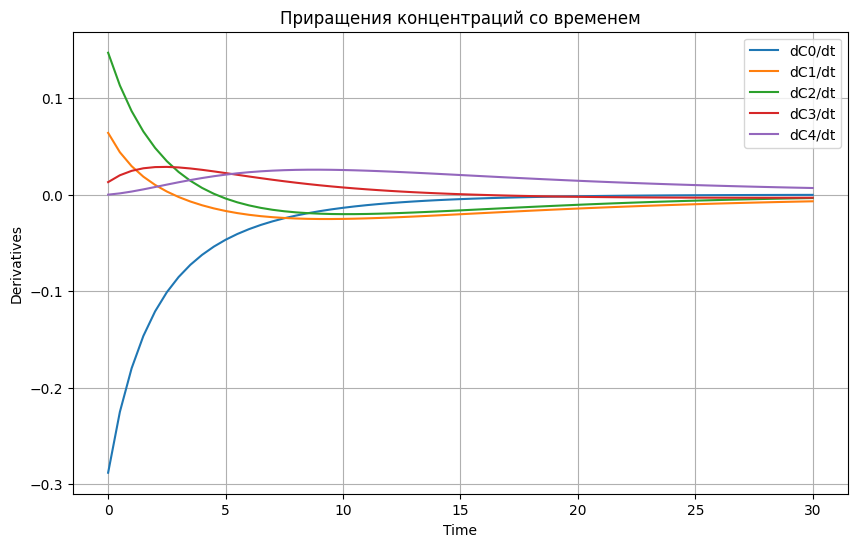

In [5]:
dCdt_TRUE = np.array([true_ode_func(t, y, k) for t, y in zip(sol.t, sol.y.T)]).T      # Приращения по истинным концентрациям C

plt.figure(figsize=(10, 6))
for i in range(dCdt_TRUE.shape[0]):
    plt.plot(sol.t, dCdt_TRUE[i], label=f'dС{i}/dt')

plt.title('Приращения концентраций со временем')
plt.xlabel('Time')
plt.ylabel('Derivatives')
plt.legend()
plt.grid()
plt.show()

# Добавление шума

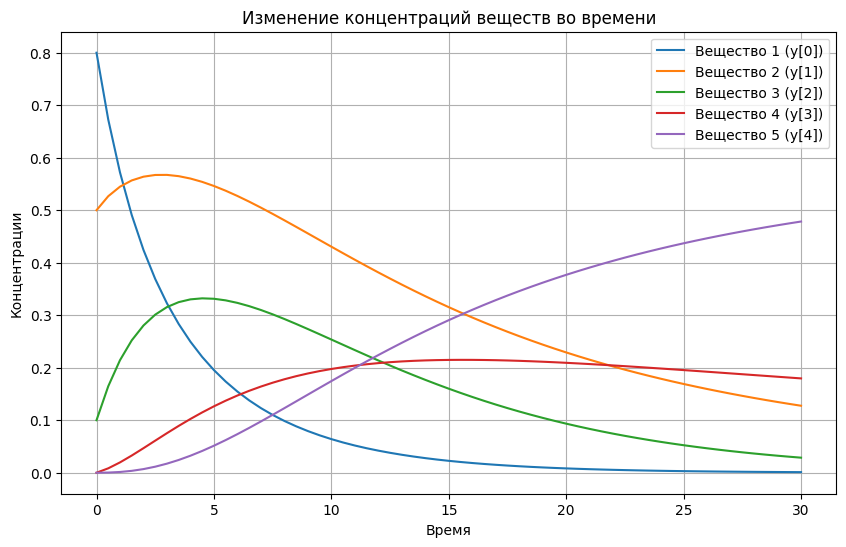

In [6]:
# Генерация шума
noise_level = 5e-2  # Уровень шума

# Создание копии, чтобы работать с ней
y_noisy = sol.y.copy()

# Генерация шума и его добавление
# noise = np.random.normal(0, noise_level * np.abs(y_noisy))
# y_noisy += noise

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, y_noisy[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


# Построение полиномиальных аппроксимаций функций изменения концентраций

Вещество C0: R^2 = 0.999991
Свободный коэффициент: 0.798890
Коэффициенты полинома, начиная с x^1:
-0.2762772827, 0.0590782110, -0.0089213118, 0.0009227087, -0.0000634603, 0.0000028275, -0.0000000781, 0.0000000012, -0.0000000000

Вещество C1: R^2 = 0.999999
Свободный коэффициент: 0.500442
Коэффициенты полинома, начиная с x^1:
0.0596839096, -0.0179382861, 0.0023967000, -0.0002286779, 0.0000154914, -0.0000007003, 0.0000000198, -0.0000000003, 0.0000000000

Вещество C2: R^2 = 0.999997
Свободный коэффициент: 0.100253
Коэффициенты полинома, начиная с x^1:
0.1438662389, -0.0344211349, 0.0044620042, -0.0003984388, 0.0000248091, -0.0000010378, 0.0000000275, -0.0000000004, 0.0000000000

Вещество C3: R^2 = 0.999999
Свободный коэффициент: -0.000111
Коэффициенты полинома, начиная с x^1:
0.0136970808, 0.0078040636, -0.0018305051, 0.0002022003, -0.0000135957, 0.0000005803, -0.0000000153, 0.0000000002, -0.0000000000

Вещество C4: R^2 = 1.000000
Свободный коэффициент: 0.000041
Коэффициенты полинома, нач

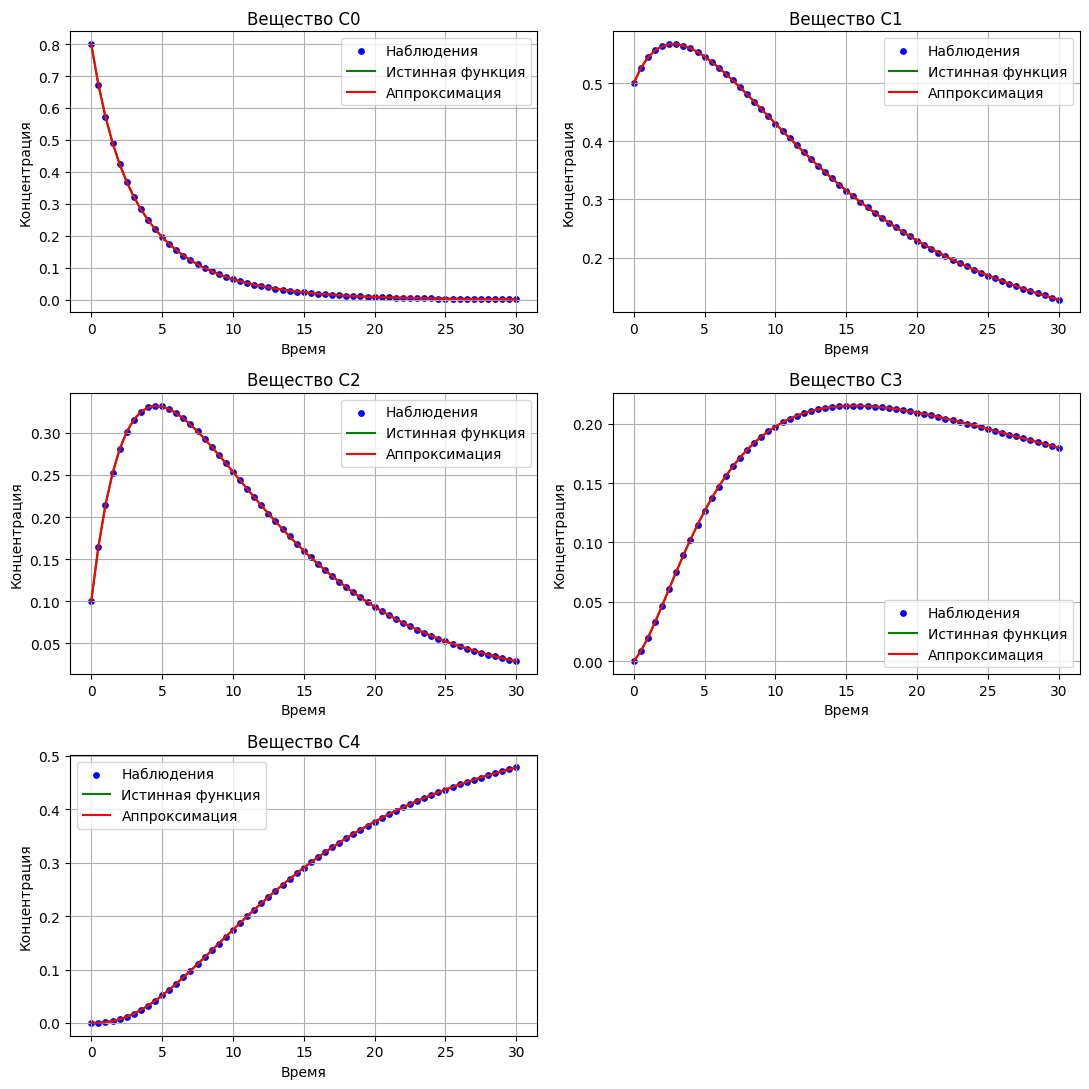

In [8]:
# Преобразование признаков в полиномиальные
poly_degree = 9
poly = PolynomialFeatures(degree=poly_degree)
time_vec = sol.t.reshape(-1, 1)         # Изменение формата временного шага для метода из sklearn
t_poly = poly.fit_transform(time_vec)

# Определяем количество строк и столбцов для сетки графиков
rows, cols = (3, 2)  # Подходит для N_SUBSTANCE = 6
fig, axes = plt.subplots(rows, cols, figsize=(11, 11), squeeze=False)   # Размер общего окна

# Массив для коэффициентов полиномов
reaction_poly_coeffs = np.zeros((N_SUBSTANCE, poly_degree + 1))  # Массив из 5 строк и 9 столбцов. Тут будут храниться коэффициенты полиномов 
                                                   # Столбцы - число коэффициентов полинома, строки - концентрации веществ

# Перебираем вещества
for i in range(N_SUBSTANCE):
    y = y_noisy[i].flatten()  # Преобразование в 1D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # Определяем текущую ось
    ax = axes[i // cols, i % cols]
    
    # Строим график
    ax.scatter(time_vec, y, color='blue', label='Наблюдения', s=15)
    ax.plot(sol.t, CONC_TRUE[i], color='green', label='Истинная функция')
    ax.plot(time_vec, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    ax.set_title(f'Вещество C{i}')
    ax.set_xlabel('Время')
    ax.set_ylabel('Концентрация')
    ax.legend()
    ax.grid()

    # Сохранение коэффициентов полинома
    reaction_poly_coeffs[i, 0] = model.intercept_
    reaction_poly_coeffs[i, 1:] = model.coef_[1:]  # Пропускаем свободный член
    
    # Вывод коэффициентов
    r2 = model.score(t_poly, y)
    print(f"Вещество C{i}: R^2 = {r2:.6f}")
    print(f"Свободный коэффициент: {model.intercept_:.6f}")
    print("Коэффициенты полинома, начиная с x^1:")
    print(f"{', '.join(f'{coef:.10f}' for coef in model.coef_[1:])}\n")

# Убираем пустые графики
for j in range(N_SUBSTANCE, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()


Здесь первый элемент `model.coef_[0]` = `0.00000000e+00` соответствует \(x^0\). Он, равен `0`, так как свободный член отдельно хранится в `model.intercept_`.

### Визуализация полиномов в более презентабельном виде

In [9]:
# Функция для форматирования полинома
def format_polynomial(coefficients):
    terms = []
    for power, coef in enumerate(coefficients):
        if abs(coef) > 1e-10:  # Пропускать практически нулевые коэффициенты
            term = f"{coef:.5e}" if power == 0 else f"{coef:.5e}*t^{power}"
            terms.append(term)
    return " + ".join(terms).replace("+ -", "- ")  # Убираем лишние плюсы перед отрицательными числами

# Генерация и вывод полиномов
for i, coeffs in enumerate(reaction_poly_coeffs):
    print(f"C{i}(t) = ", end='')
    print(format_polynomial(coeffs))


C0(t) = 7.98890e-01 - 2.76277e-01*t^1 + 5.90782e-02*t^2 - 8.92131e-03*t^3 + 9.22709e-04*t^4 - 6.34603e-05*t^5 + 2.82753e-06*t^6 - 7.80566e-08*t^7 + 1.21022e-09*t^8
C1(t) = 5.00442e-01 + 5.96839e-02*t^1 - 1.79383e-02*t^2 + 2.39670e-03*t^3 - 2.28678e-04*t^4 + 1.54914e-05*t^5 - 7.00253e-07*t^6 + 1.97685e-08*t^7 - 3.13350e-10*t^8
C2(t) = 1.00253e-01 + 1.43866e-01*t^1 - 3.44211e-02*t^2 + 4.46200e-03*t^3 - 3.98439e-04*t^4 + 2.48091e-05*t^5 - 1.03780e-06*t^6 + 2.75021e-08*t^7 - 4.14751e-10*t^8
C3(t) = -1.10634e-04 + 1.36971e-02*t^1 + 7.80406e-03*t^2 - 1.83051e-03*t^3 + 2.02200e-04*t^4 - 1.35957e-05*t^5 + 5.80301e-07*t^6 - 1.53339e-08*t^7 + 2.28610e-10*t^8
C4(t) = 4.09179e-05 - 2.17955e-04*t^1 + 1.13848e-03*t^2 + 4.98804e-04*t^3 - 8.97047e-05*t^4 + 7.08804e-06*t^5 - 3.23175e-07*t^6 + 8.78379e-09*t^7 - 1.32458e-10*t^8


Нахождение производных от функций концентраций веществ

Так как в нашем случае в качестве функций используются только полиномы, то я напишу функцию вручную

`print(reaction_poly_coeffs)` - чтобы посмотреть массив с коэффициентами полиномов для каждого вещества

In [10]:
def differentiate_polynomial(coefficients):
    degree = len(coefficients) # степень полинома + 1
    return np.array([coefficients[i] * i for i in range(1, degree)])

reaction_poly_derivatives = np.array([differentiate_polynomial(coeff) for coeff in reaction_poly_coeffs])

print(reaction_poly_derivatives)

[[-2.76277283e-01  1.18156422e-01 -2.67639354e-02  3.69083490e-03
  -3.17301367e-04  1.69652030e-05 -5.46395928e-07  9.68173880e-09
  -7.23885951e-11]
 [ 5.96839096e-02 -3.58765721e-02  7.19009990e-03 -9.14711704e-04
   7.74567841e-05 -4.20151538e-06  1.38379412e-07 -2.50680265e-09
   1.91110877e-11]
 [ 1.43866239e-01 -6.88422699e-02  1.33860126e-02 -1.59375506e-03
   1.24045685e-04 -6.22682691e-06  1.92514586e-07 -3.31800875e-09
   2.43247922e-11]
 [ 1.36970808e-02  1.56081272e-02 -5.49151516e-03  8.08801119e-04
  -6.79785674e-05  3.48180702e-06 -1.07337208e-07  1.82887681e-09
  -1.32216894e-11]
 [-2.17955317e-04  2.27695904e-03  1.49641097e-03 -3.58818841e-04
   3.54401921e-05 -1.93904875e-06  6.14865092e-08 -1.05966603e-09
   7.68770838e-12]]


## Визуализация различий между приращениями в обратной и прямой задачах

### Оригинал (прямая задача)

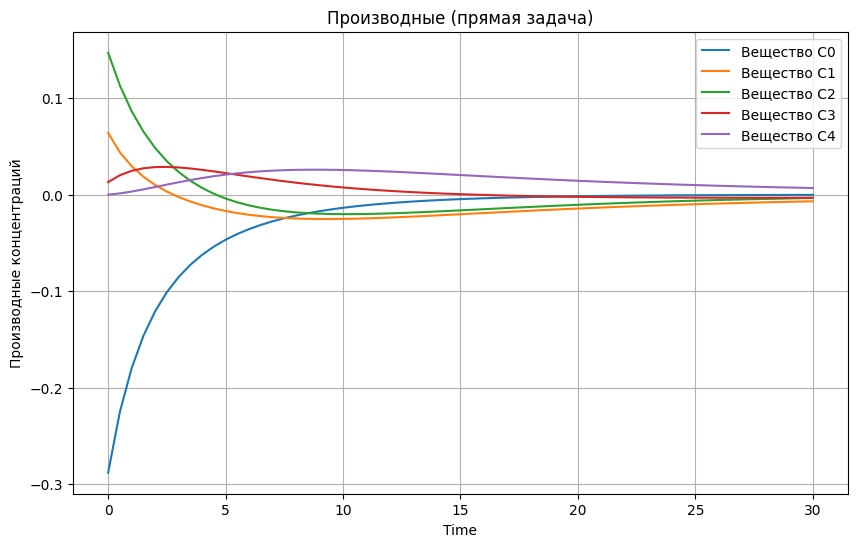

In [11]:
# Диапазон значений x
# x = np.linspace(0, 30, 61)    # Базово использовать tsteps

# Построение графиков
plt.figure(figsize=(10, 6))

for i in range(N_SUBSTANCE):
    plt.plot(tsteps, dCdt_TRUE[i], label=f'Вещество C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные (прямая задача)')
plt.legend()
plt.grid()
plt.show()


### Пародия (обратная задача)

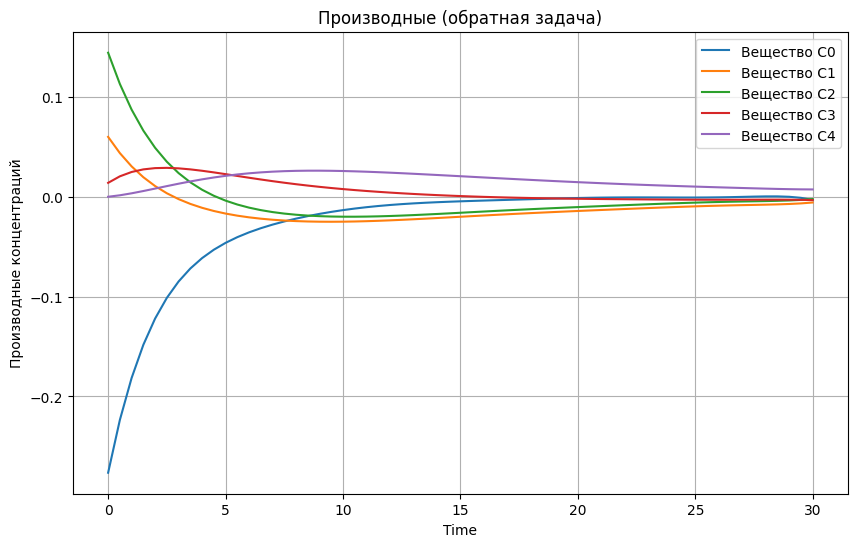

In [12]:
dCdt_predict = np.zeros_like(dCdt_TRUE)         # Приращения в обратной задаче

# Построение графиков
plt.figure(figsize=(10, 6))

for i, coeffs in enumerate(reaction_poly_derivatives):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    dCdt_predict[i, :] = y

    # Вывод на график
    plt.plot(tsteps, dCdt_predict[i], label=f'Вещество C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные (обратная задача)')
plt.legend()
plt.grid()
plt.show()

### Различие между приращениями

### Визуализация в plotly

In [13]:
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(N_SUBSTANCE):
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_TRUE[i] - dCdt_predict[i], 
        mode='lines', 
        name=f'Приращение C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Производные концентраций веществ',
    xaxis_title='Time',
    yaxis_title='Производные концентраций',
    legend_title='Приращения',
    template='plotly_white',
    width=1400,  # Ширина холста
    height=800   # Высота холста
)

fig.show()

## Частотное что-то там

In [13]:
fig = go.Figure()

# Дискретизация по времени (шаг)
dt = tsteps[1] - tsteps[0]  # Предполагаем, что шаг одинаковый

# Добавляем спектры для каждого вещества
for i, coeffs in enumerate(reaction_poly_derivatives):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    signal = dCdt_TRUE[i] - y  # Исходный сигнал (разность производных)

    # Применяем БПФ (FFT)
    fft_values = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=dt)  # Вычисляем частоты

    # Берём только положительные частоты и нормируем амплитуды
    mask = freqs > 0
    freqs, fft_values = freqs[mask], np.abs(fft_values[mask])  

    # Добавляем в график
    fig.add_trace(go.Scatter(
        x=freqs, 
        y=fft_values, 
        mode='lines', 
        name=f'Частоты C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Частотный спектр производных концентраций',
    xaxis_title='Frequency (Hz)',
    yaxis_title='Amplitude',
    legend_title='Вещества',
    template='plotly_white',
    width=1000,
    height=600
)

fig.show()


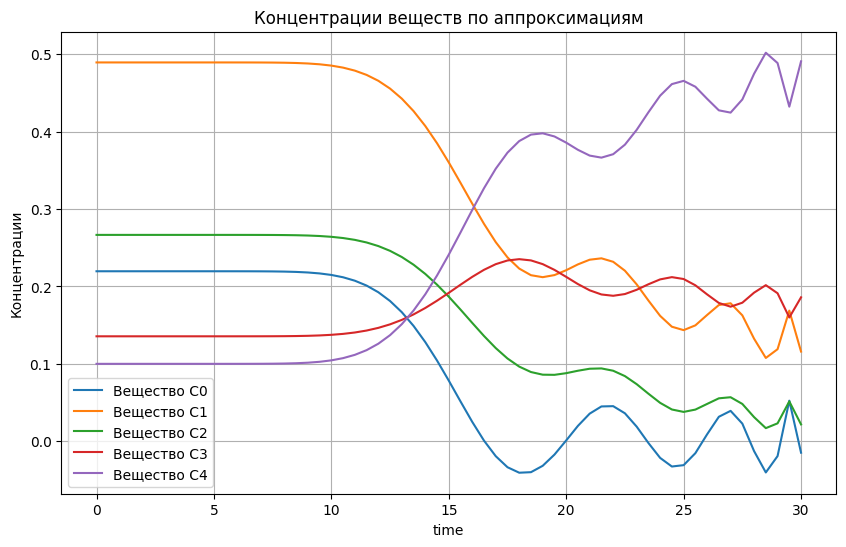

In [14]:
# Диапазон значений x
# t = np.linspace(0, 30, 100)       # Базово использовать tsteps

# Построение графиков
plt.figure(figsize=(10, 6))
for i, coeffs in enumerate(reaction_poly_coeffs):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    plt.plot(tsteps, y, label=f'Вещество C{i}')

plt.xlabel('time')
plt.ylabel('Концентрации')
plt.title('Концентрации веществ по аппроксимациям')
plt.legend()
plt.grid()
plt.show()


# Проверяем концентрации

Статистика по ошибкам

In [15]:
# шаг по времени
# t = np.linspace(0, 30, 31)
error_matrix = np.zeros_like(y_noisy)  # пустая матрица той же размерности

for i, coeffs in enumerate(reaction_poly_coeffs):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    # error_matrix[i] = y_noisy[i] - y  # Заполняем матрицу ошибками
    error_matrix[i] = abs(y_noisy[i] - y)  # Заполняем матрицу ошибками

# Вычисляем статистики по всей матрице
max_value = np.max(error_matrix)
min_value = np.min(error_matrix)
mean_value = np.mean(error_matrix)
median_value = np.median(error_matrix)

# Вычисляем статистики по каждой строке
max_per_row = np.max(error_matrix, axis=1)
min_per_row = np.min(error_matrix, axis=1)
mean_per_row = np.mean(error_matrix, axis=1)
median_per_row = np.median(error_matrix, axis=1)

# Вывод общих статистик
print(f"Максимальное значение ошибки: {max_value:.6f}")
print(f"Минимальное значение ошибки: {min_value:.6f}")
print(f"Среднее значение ошибки: {mean_value:.6f}")
print(f"Медиана ошибки: {median_value:.6f}")

# Вывод статистик по каждой строке
# for i in range(error_matrix.shape[0]):
#     print(f"\nСтрока {i}:")
#     print(f"  Максимум: {max_per_row[i]:.6f}")
#     print(f"  Минимум: {min_per_row[i]:.6f}")
#     print(f"  Среднее: {mean_per_row[i]:.6f}")
#     print(f"  Медиана: {median_per_row[i]:.6f}")

Максимальное значение ошибки: 0.580437
Минимальное значение ошибки: 0.000982
Среднее значение ошибки: 0.046481
Медиана ошибки: 0.030910


# Вычисление k по данным обратной задачи

In [16]:
k_predict = np.zeros((N_REACTION, len(tsteps)))                     # k предсказанные
k_TRUE = np.zeros((N_REACTION, len(tsteps)))                        # k по изначальным данным
k_test_1 = np.zeros((N_REACTION, len(tsteps)))                      # k для теста
k_test_2 = np.zeros((N_REACTION, len(tsteps)))                      # k для теста

W_predict = np.zeros((N_REACTION, len(tsteps)))                     # W(скорости реакций) предсказанные
W_TRUE = np.zeros((N_REACTION, len(tsteps)))                        # W(скорости реакций) по изначальным данным
W_test_1 = np.zeros((N_REACTION, len(tsteps)))                      # W для теста
W_test_2 = np.zeros((N_REACTION, len(tsteps)))                      # W для теста

C_predict = np.zeros((N_SUBSTANCE, len(tsteps)))                    # C(концентрации) предсказанные
C_TRUE = np.zeros((N_SUBSTANCE, len(tsteps)))                       # C(концентрации) по изначальным данным
C_test_1 = np.zeros((N_SUBSTANCE, len(tsteps)))                     # C для теста
C_test_2 = np.zeros((N_SUBSTANCE, len(tsteps)))                     # C для теста


In [17]:
matrix_transformations = np.linalg.inv(MATR @ MATR.T) @ MATR

In [18]:
print(matrix_transformations)

[[-0.3125  0.375  -0.3125 -0.3125  0.0625]
 [-0.3125 -0.625   0.6875  0.6875  0.0625]
 [-0.25   -0.5    -0.25    0.75    0.25  ]
 [-0.1875 -0.375  -0.1875 -0.1875  0.4375]]


### Сохранение k по C-предсказанная, dC-предсказанная

In [19]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps):
    W = matrix_transformations @ dCdt_predict.T[i]
    C = np.array([np.polyval(substance[::-1], val) for substance in reaction_poly_coeffs])
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_predict[:, i] = W
    C_predict[:, i] = C
    k_predict[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred

# print(k_pred)  # Выводим матрицу


### Сохранение k по С-начальная, dC-начальная

In [20]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps):
    W = matrix_transformations @ dCdt_TRUE.T[i]
    C = CONC_TRUE[:, i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_TRUE[:, i] = W
    C_TRUE[:, i] = C
    k_TRUE[:, i] = W / result  # Заполняем i-й столбец матрицы k_eval

# print(k_eval)  # Выводим матрицу


C:\Users\GeraschenkoKM\AppData\Local\Temp\ipykernel_15600\1191449194.py:10: RuntimeWarning:

divide by zero encountered in divide



In [21]:
print(k_TRUE)

[[0.1        0.1        0.1        0.10000001 0.1        0.1
  0.1        0.09999999 0.10000001 0.10000001 0.10000002 0.10000002
  0.09999999 0.09999998 0.10000001 0.10000004 0.1        0.09999999
  0.09999997 0.10000003 0.0999999  0.09999995 0.1        0.09999988
  0.09999996 0.10000024 0.09999999 0.09999993 0.09999991 0.10000036
  0.10000013 0.10000022 0.10000001 0.09999995 0.09999952 0.100001
  0.09999881 0.10000053 0.09999903 0.1000035  0.10000358 0.09999999
  0.09999841 0.10000066 0.09999376 0.10000255 0.09999655 0.10000291
  0.10000899 0.09999243 0.10000995 0.09998227 0.09998717 0.09997519
  0.10002699 0.10003567 0.1000605  0.10001472 0.10003898 0.10001333
  0.09991426]
 [0.20000002 0.2        0.2        0.20000001 0.2        0.20000001
  0.20000001 0.20000001 0.2        0.2        0.2        0.19999999
  0.2        0.19999999 0.2        0.2        0.20000001 0.20000002
  0.20000002 0.2        0.2        0.20000002 0.2        0.20000003
  0.20000002 0.19999998 0.20000001 0.200000

## Генерация k в ходе обратной задачи 

In [22]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['С-начальная, dC-начальная', 'С-предсказанная, dC-предсказанная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


Скачки всё равно остаются, и чем дальше по времени, тем сильнее графики колбасит

In [23]:
print(C_predict)

[[ 0.21956297  0.21956297  0.21956297  0.21956297  0.21956297  0.21956297
   0.21956297  0.21956296  0.21956288  0.21956256  0.21956143  0.21955794
   0.21954836  0.21952464  0.21947076  0.21935725  0.21913352  0.21871809
   0.2179871   0.21676257  0.2148024   0.21179488  0.2073614   0.20107076
   0.19246841  0.18112224  0.16668474  0.14896783  0.12802338  0.10421826
   0.07829002  0.05136678  0.02493602  0.00074979 -0.01933878 -0.03360204
  -0.0407087  -0.04000465 -0.03175581 -0.01729521  0.00098484  0.01984381
   0.03562936  0.0449188   0.04528795  0.03606584  0.01887495 -0.00227634
  -0.02156338 -0.0326927  -0.03093843 -0.01546099  0.00890124  0.0315644
   0.03920857  0.02273336 -0.01278749 -0.04036575 -0.01922334  0.05238667
  -0.01483028]
 [ 0.48934724  0.48934724  0.48934724  0.48934724  0.48934724  0.48934724
   0.48934724  0.48934723  0.48934717  0.4893469   0.48934594  0.489343
   0.4893349   0.48931481  0.48926907  0.48917248  0.48898161  0.48862618
   0.4879988   0.48694414 

# Test_1

### Вычисление k по C-начальная, dС-предсказанная
### Вычисление k по C-предсказанная, dС-начальная

In [24]:
for i, val in enumerate(tsteps):
    W = W_predict[:, i]
    C = CONC_TRUE[:, i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    k_test_1[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred

for i, val in enumerate(tsteps):
    W = W_TRUE[:, i]
    C = C_predict[:, i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    k_test_2[:, i] = W / result  # Заполняем i-й столбец матрицы k_eval

C:\Users\GeraschenkoKM\AppData\Local\Temp\ipykernel_15600\3648013887.py:6: RuntimeWarning:

divide by zero encountered in divide



## Генерация k в ходе обратной задачи 

In [25]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['C-начальная, dС-предсказанная', 'C-предсказанная, dС-начальная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_1[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_2[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


##

In [26]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['C-начальная, dС-предсказанная', 'C-предсказанная, dС-предсказанная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_1[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [27]:
C_test_1 = np.abs(C_predict)

In [28]:
for i, val in enumerate(tsteps):
    W = W_predict[:, i]
    C = C_test_1.T[i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    k_test_1[:, i] = W / result  # Заполняем i-й столбец матрицы k_eval

In [29]:
print(W_predict)

[[ 1.34884581e-18  1.54321856e-18  1.05620352e-15  1.64209694e-13
   5.77565766e-12  8.91414221e-11  8.13993821e-10  5.16248286e-09
   2.50316978e-08  9.87311368e-08  3.30481140e-07  9.67552471e-07
   2.53331928e-06  6.03241288e-06  1.32346934e-05  2.70261702e-05
   5.17874492e-05  9.37265206e-05  1.61058421e-04  2.63897840e-04
   4.13722095e-04  6.22281113e-04  8.99886017e-04  1.25310198e-03
   1.68200069e-03  2.17728100e-03  2.71772189e-03  3.26855996e-03
   3.78144868e-03  4.19662178e-03  4.44771632e-03  4.46939288e-03
   4.20742361e-03  3.63033376e-03  2.74104573e-03  1.58639006e-03
   2.61950995e-04 -1.09033379e-03 -2.29394093e-03 -3.15991988e-03
  -3.51867006e-03 -3.25813251e-03 -2.36236005e-03 -9.41655452e-04
   7.56535724e-04  2.36706206e-03  3.46531321e-03  3.66612264e-03
   2.75365210e-03  8.16150867e-04 -1.66025368e-03 -3.80316563e-03
  -4.54379795e-03 -3.04033253e-03  6.79850585e-04  5.03622289e-03
   6.66242656e-03  1.67492465e-03 -9.58411548e-03 -1.08953300e-02
   5.40682

In [30]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['C-модифицированная, dС-предсказанная', 'C-предсказанная, dС-предсказанная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_1[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [31]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['C-модифицированная, dС-предсказанная', 'C-предсказанная, dС-предсказанная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_1[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_test_2[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


## Вывод интересных графиков

In [32]:
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['W-истинная', 'W-предсказанная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-0.05, 0.2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-0.05, 0.2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


W-скорости реакций предсказываются отрицательными. Они не должны быть отрицательными

In [33]:
colors = ['blue', 'red', 'green', 'purple','black']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['dCdt-истинная', 'dCdt-предсказанная'])

# Первый график
for i in range(N_SUBSTANCE):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график
for i in range(N_SUBSTANCE):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-0.3, 0.2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-0.3, 0.2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [34]:
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['k-истинная', 'k-предсказанная'])

# Первый график
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-1, 1], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-1, 1], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [35]:
# Точка в которой считаем значения
t_1 = 0.5
t_2 = 6
t_3 = 15

# Вычисление значения полиномов в точке t
dC_1 = np.array([np.polyval(substance[::-1], t_1) for substance in reaction_poly_derivatives])
dC_2 = np.array([np.polyval(substance[::-1], t_2) for substance in reaction_poly_derivatives])
dC_3 = np.array([np.polyval(substance[::-1], t_3) for substance in reaction_poly_derivatives])

print('Производные концентраций в моменты времени:')
print('dC(t=0.5) = ', dC_1)
print('dC(t=6)   = ', dC_2)
print('dC(t=12)  = ', dC_3)

# Вычисление значения скоростей реакций в моменты времени
W_1 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_1  # t_1 = 0.5
W_2 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_2  # t_2 = 6
W_3 = np.linalg.inv(MATR @ MATR.T) @ MATR @ dC_3  # t_3 = 12

print()
print('Вектора скоростей реакций в моменты времени:')
print('W(t=0.5) = ', W_1)
print('W(t=6)   = ', W_2)
print('W(t=12)  = ', W_3)

# Вычисление концентраций веществ в моменты времени
C_1 = np.array([np.polyval(substance[::-1], t_1) for substance in reaction_poly_coeffs])
C_2 = np.array([np.polyval(substance[::-1], t_2) for substance in reaction_poly_coeffs])
C_3 = np.array([np.polyval(substance[::-1], t_3) for substance in reaction_poly_coeffs])

print()
print('Концентрации в моменты времени:')
print('C(t=0.5) = ', C_1)
print('C(t=6)   = ', C_2)
print('C(t=12)  = ', C_3)

Производные концентраций в моменты времени:
dC(t=0.5) =  [-1.79619604e-17 -1.49572181e-17 -8.93542316e-18  7.31050973e-18
  1.65004367e-17]
dC(t=6)   =  [-2.95764616e-05 -2.50239050e-05 -1.50444806e-05  1.19970793e-05
  2.75572244e-05]
dC(t=12)  =  [-0.05329149 -0.05151468 -0.03240718  0.02084084  0.05596239]

Вектора скоростей реакций в моменты времени:
W(t=0.5) =  [1.54321856e-18 1.48755233e-17 2.38109464e-17 1.65004367e-17]
W(t=6)   =  [2.53331928e-06 2.45098230e-05 3.95543036e-05 2.75572243e-05]
W(t=12)  =  [0.00444772 0.04439605 0.07680323 0.05596239]

Концентрации в моменты времени:
C(t=0.5) =  [0.21956297 0.48934724 0.26654759 0.13552828 0.09995415]
C(t=6)   =  [0.21954836 0.4893349  0.26654017 0.13553421 0.09996775]
C(t=12)  =  [0.07829002 0.36019318 0.18671955 0.19170786 0.24103066]


In [36]:
# Вычисление вектора с использованием заданной формулы
result_1 = np.prod(C_1 ** MATR_PLUS, axis=1)
result_2 = np.prod(C_2 ** MATR_PLUS, axis=1)
result_3 = np.prod(C_3 ** MATR_PLUS, axis=1)

In [37]:
print(f'k(t={t_1}) = {W_1/result_1}')
print(f'k(t={t_2}) = {W_2/result_2}')
print(f'k(t={t_3}) = {W_3/result_3}')
print()
print('Истинные значения:' ,k)

k(t=0.5) = [3.20117369e-17 6.77506009e-17 8.93309394e-17 2.48798853e-16]
k(t=6) = [5.25568742e-05 1.11637467e-04 1.48399031e-04 4.15508930e-04]
k(t=15) = [0.72564519 0.56707171 0.41132934 0.81043998]

Истинные значения: tensor([0.1000, 0.2000, 0.1300, 0.3000])


In [38]:
print(dCdt_TRUE.shape)
print(dCdt_predict.shape)

(5, 61)
(5, 61)


In [39]:
print(dCdt_TRUE[:, 5] - dCdt_predict[:, 5])

[-0.10104803  0.00322521  0.03466793  0.02874692  0.01039425]


In [40]:
print(reaction_poly_coeffs)

[[ 2.19562972e-01 -1.56992804e-17  3.16944919e-21 -2.51455466e-23
  -2.58967668e-25 -1.92265783e-24 -2.63920150e-23 -3.46875304e-22
  -4.32376461e-21 -5.03946831e-20 -5.37661822e-19 -5.08033470e-18
  -4.02122555e-17 -2.39201867e-16 -8.02443607e-16  1.92671916e-16
  -1.87275310e-17  9.62435384e-19 -2.76877493e-20  4.23295285e-22
  -2.68816460e-24]
 [ 4.89347242e-01 -1.30716669e-17  2.63902032e-21 -2.09374928e-23
  -2.15627415e-25 -1.60089175e-24 -2.19752864e-23 -2.88827077e-22
  -3.60022649e-21 -4.19620647e-20 -4.47700349e-19 -4.23038354e-18
  -3.34858434e-17 -1.99204198e-16 -6.68413013e-16  1.59265403e-16
  -1.53793254e-17  7.85819471e-19 -2.24910206e-20  3.42267859e-22
  -2.16459189e-24]
 [ 2.66547588e-01 -7.80866140e-18  1.57649100e-21 -1.25076388e-23
  -1.28810874e-25 -9.56337406e-25 -1.31275762e-23 -1.72539661e-22
  -2.15071164e-21 -2.50674978e-20 -2.67450895e-19 -2.52720289e-18
  -2.00045081e-17 -1.19008450e-16 -3.99359014e-16  9.48588413e-17
  -9.13484692e-18  4.65603498e-19 -1.3

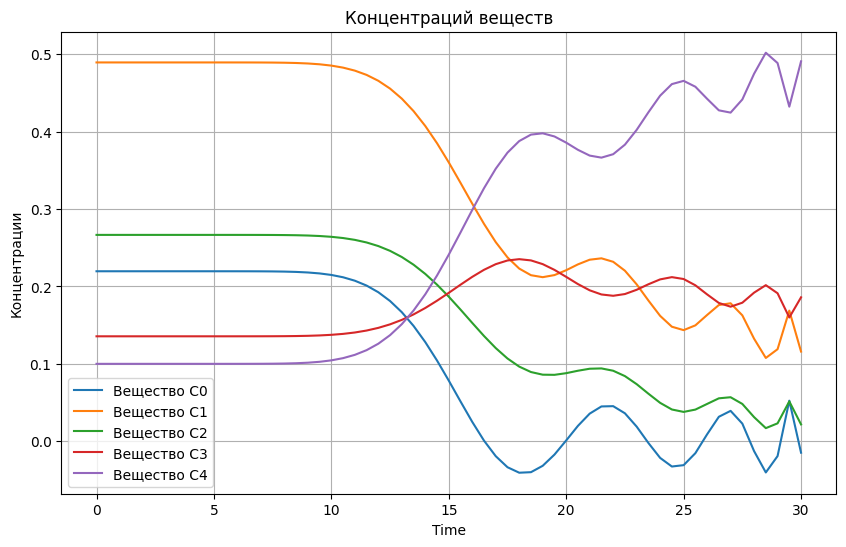

In [41]:
conc_pred = np.zeros_like(dCdt_TRUE)      # Будущая матрица концентраций

# Построение графиков
plt.figure(figsize=(10, 6))

for i, coeffs in enumerate(reaction_poly_coeffs):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    conc_pred[i, :] = y

    # Вывод на график
    plt.plot(tsteps, conc_pred[i], label=f'Вещество C{i}')

plt.xlabel('Time')
plt.ylabel('Концентрации')
plt.title('Концентраций веществ')
plt.legend()
plt.grid()
plt.show()

In [42]:
print(conc_pred)

[[ 0.21956297  0.21956297  0.21956297  0.21956297  0.21956297  0.21956297
   0.21956297  0.21956296  0.21956288  0.21956256  0.21956143  0.21955794
   0.21954836  0.21952464  0.21947076  0.21935725  0.21913352  0.21871809
   0.2179871   0.21676257  0.2148024   0.21179488  0.2073614   0.20107076
   0.19246841  0.18112224  0.16668474  0.14896783  0.12802338  0.10421826
   0.07829002  0.05136678  0.02493602  0.00074979 -0.01933878 -0.03360204
  -0.0407087  -0.04000465 -0.03175581 -0.01729521  0.00098484  0.01984381
   0.03562936  0.0449188   0.04528795  0.03606584  0.01887495 -0.00227634
  -0.02156338 -0.0326927  -0.03093843 -0.01546099  0.00890124  0.0315644
   0.03920857  0.02273336 -0.01278749 -0.04036575 -0.01922334  0.05238667
  -0.01483028]
 [ 0.48934724  0.48934724  0.48934724  0.48934724  0.48934724  0.48934724
   0.48934724  0.48934723  0.48934717  0.4893469   0.48934594  0.489343
   0.4893349   0.48931481  0.48926907  0.48917248  0.48898161  0.48862618
   0.4879988   0.48694414 

In [43]:
print(CONC_TRUE)

[[8.00000000e-01 6.72660406e-01 5.72023401e-01 4.90876485e-01
  4.24346285e-01 3.69045530e-01 3.22615885e-01 2.83236774e-01
  2.49538927e-01 2.20544878e-01 1.95476490e-01 1.73674663e-01
  1.54599076e-01 1.37839843e-01 1.23095439e-01 1.10099688e-01
  9.86138148e-02 8.84264452e-02 7.93536951e-02 7.12530542e-02
  6.40236770e-02 5.75731623e-02 5.18151611e-02 4.66693775e-02
  4.20615676e-02 3.79235403e-02 3.41940639e-02 3.08326871e-02
  2.78081044e-02 2.50893551e-02 2.26468894e-02 2.04525689e-02
  1.84796660e-02 1.67028644e-02 1.50982589e-02 1.36437662e-02
  1.23264223e-02 1.11361360e-02 1.00622052e-02 9.09430633e-03
  8.22249433e-03 7.43720267e-03 6.72924334e-03 6.08980685e-03
  5.51046223e-03 4.98367459e-03 4.50592387e-03 4.07364635e-03
  3.68312656e-03 3.33076306e-03 3.01306852e-03 2.72666965e-03
  2.46830723e-03 2.23483612e-03 2.02322525e-03 1.83067851e-03
  1.65614973e-03 1.49829387e-03 1.35553068e-03 1.22640425e-03
  1.10958301e-03]
 [5.00000000e-01 5.26680429e-01 5.44858360e-01 5.567

In [44]:
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(N_REACTION):
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=CONC_TRUE[i], 
        mode='lines', 
        name=f'Приращение C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Производные концентраций веществ',
    xaxis_title='Time',
    yaxis_title='Производные концентраций',
    legend_title='Приращения',
    template='plotly_white',
    width=1000,  # Ширина холста
    height=600   # Высота холста
)

fig.show()